# Final

In [1]:
# # -- Uncomment and run this cell on Google Colab
# !wget math.gmu.edu/~igriva/data.zip
# !mkdir ../data
# !unzip data.zip -d ../data

In [2]:
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import combinations, product
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics.pairwise import euclidean_distances
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix

sns.set_context("paper")

In [3]:
data_path = Path().resolve().parent / "data"
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)

In [4]:
def get_data(data_path, labels, n_train_label, n_test_label, rng):
    """
    Returns train and test data for some labels.

    Parameters
    ----------

    data_path: pathlib.PosixPath
        Path of datasets

    labels: list
        Digits from MNIST set

    n_train_label: int
        Number of train samples for each label

    n_test_label: int
        Number of test samples for each label

    rng: numpy.random._generator.Generator
        Seed for reproducibility

    Returns
    -------
    tuple of np.array
        X_train, y_train, X_test, y_test

    """
    train_list = []  # Auxiliary list of train datasets
    for f_train in data_path.glob("train*.txt"):
        if f_train.stem.removeprefix("train") not in map(str, labels):
            continue  # Skips labels
        raw_train = np.loadtxt(f_train)
        if n_train_label is not None:
            # Sample
            indices_train = rng.choice(raw_train.shape[0], n_train_label, replace=False)
            raw_train = raw_train[indices_train, :]
        target_train = raw_train[:, [0]]  # Target values, i.e. digit
        features_train = raw_train[:, 1:] / 255
        train_list.append(np.hstack((target_train, features_train)))
    train_data = np.vstack(train_list)  # Concatenate train datasets

    test_list = []
    for f_test in data_path.glob("test*.txt"):
        if f_test.stem.removeprefix("test") not in map(str, labels):
            continue  # Skip labels
        raw_test = np.loadtxt(f_test)
        if n_test_label is not None:
            # Sample
            indices_test = rng.choice(raw_test.shape[0], n_test_label, replace=False)
            raw_test = raw_test[indices_test, :]
        target_test = raw_test[:, [0]]
        features_test = raw_test[:, 1:] / 255
        test_list.append(np.hstack((target_test, features_test)))
    test_data = np.vstack(test_list)

    X_train = train_data[:, 1:]
    y_train = train_data[:, 0].astype(int)
    X_test = test_data[:, 1:]
    y_test = test_data[:, 0].astype(int)
    return X_train, y_train, X_test, y_test


def filter_data(X, y, labels):
    mask = np.isin(y, labels)
    X_new = X[mask, :]
    y_new = y[mask]
    return X_new, y_new

1. SVM

In [5]:
def radial_basis(X1, X2, gamma):
    K = np.exp(-gamma * euclidean_distances(X1, X2, squared=True))
    return K


class SVM_binary():
    def __init__(self, C, gamma):
        self.C = C
        self.gamma = gamma
        self.X_train = None
        self.y_train = None
        self.alpha = None
        self.I = None
        self.b = None

    def train(self, X_train, y_train):
        n_train = X_train.shape[0]
        self.X_train = X_train
        self.y_train = y_train
        K_train = radial_basis(self.X_train, self.X_train, self.gamma)
        M = csc_matrix(np.outer(self.y_train, self.y_train) * K_train ) # Quadratic
        e = np.ones(shape=(n_train, 1), dtype=float)  # Linear
        # G = np.identity(n=n_train, dtype=float)  # Inequality constraint
        # h = self.C * e)  # RHS inequality constraint
        A = csc_matrix(self.y_train.reshape(1, -1).astype(float))  # Equality constraint
        b = np.array(0.0)  # RHS equality constraint
        lb = np.zeros(shape=(n_train, 1), dtype=float)
        ub = self.C * e
        # Quadratic Solver
        self.alpha = solve_qp(M, -e, None, None, A, b, lb, ub, solver="osqp")
        self.I = np.argwhere(self.alpha > 0).flatten()
        self.I_C = np.argwhere((self.alpha > 0) & (self.alpha < self.C)).flatten()
        # Bias is computed as the median of possible biases
        self.b_array = (
            np.sum(
                self.y_train[self.I] * self.alpha[self.I] * K_train[np.ix_(self.I_C, self.I)],
                axis=1
            ) - self.y_train[self.I_C]
        )
        self.b = np.median(self.b_array)

    def predict(self, X_test, return_class_number=False):
        n_test = X_test.shape[0]
        K_test = radial_basis(self.X_train, X_test, self.gamma)
        class_number = (
            np.sum(
                self.y_train[self.I, np.newaxis]
                * self.alpha[self.I, np.newaxis]
                * K_test[self.I, :],
                axis=0
            )
            - self.b * np.ones(shape=(n_test))
        )
        if return_class_number:
            # Only return class number
            return class_number
        else:
            y_pred = np.where(class_number > 0, 1, -1)
            return y_pred

    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(y_pred == y_test)

2. Classification 3 vs 6

In [6]:
gamma = 0.03
C = 100

In [7]:
labels_36 = np.array([3, 6])
n_train_label = 500  # each label
n_test_label = 500  # each label
X_train_36, y_train_36, X_test_36, y_test_36 = get_data(
    data_path,
    labels_36,
    n_train_label,
    n_test_label,
    rng
)
min_label = np.min(labels_36)
y_train_bin_36 = np.where(y_train_36 == min_label, -1, 1)  # y_i \in {-1, 1}
y_test_bin_36 = np.where(y_test_36 == min_label, -1, 1)  # y_i \in {-1, 1}

In [8]:
svm_36 = SVM_binary(C=C, gamma=gamma)
svm_36.train(X_train_36, y_train_bin_36)

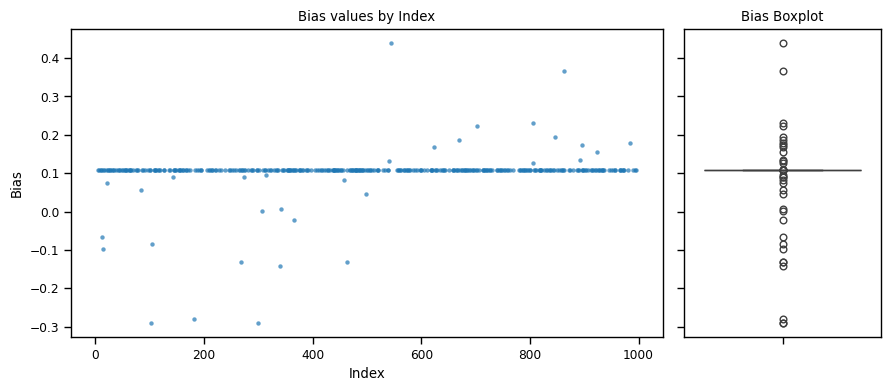

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
sns.scatterplot(
    x=svm_36.I_C,
    y=svm_36.b_array,
    # edgecolor="none",
    s=10,
    alpha=0.7,
    linewidth=0,
    ax=ax1
)
ax1.set_xlabel("Index")
ax1.set_ylabel("Bias")
ax1.set_title("Bias values by Index")
ax2.set_title("Bias Boxplot")
sns.boxplot(svm_36.b_array, ax=ax2)

fig.tight_layout()
fig.savefig(
    f"final_biases.png",
    dpi=300
)

3. Accuracy 3 vs 6

In [10]:
svm_36.accuracy(X_test_36, y_test_bin_36)

0.999

4. Reduction of training examples

In [11]:
factors = [0.75, 0.90, 0.95]  # Reduction factors
n_train = X_train_36.shape[0]

In [12]:
test_accuracy_36 = {}  # Test accuracy dictionary
for factor in factors:
    n_per_label = int((n_train - n_train * factor) / len(labels_36))  # N samples
    X_train_tmp_list = []
    y_train_tmp_list = []
    # Sample each label
    for label in labels_36:
        mask_train = y_train_36 == label
        y_train_tmp = y_train_36[mask_train]
        X_train_tmp = X_train_36[mask_train, :]
        idx = rng.choice(y_train_tmp.shape[0], n_per_label, replace=False)
        X_train_tmp_list.append(X_train_tmp[idx, :])
        y_train_tmp_list.append(y_train_tmp[idx])
    X_train = np.vstack(X_train_tmp_list)
    y_train = np.concatenate(y_train_tmp_list)
    y_train_bin = np.where(y_train == min_label, -1, 1)  # Binary transformation
    y_test_bin = np.where(y_test_36 == min_label, -1, 1)
    # SVM train and predict
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train, y_train_bin)
    test_accuracy_36[factor] = svm.accuracy(X_test_36, y_test_bin)

In [13]:
test_accuracy_36

{0.75: 0.998, 0.9: 0.982, 0.95: 0.982}

5. Reduction of pixeles uniformly

In [14]:
n_features = X_train_36.shape[1]
test_accuracy_pixel_36 = {}
for factor in factors:
    n_features_new = int(n_features * (1 - factor))  # Number of pixels
    idx = np.linspace(0, n_features, num=n_features_new, endpoint=False, dtype=int)
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train_36[:, idx], y_train_bin_36)
    test_accuracy_pixel_36[factor] = svm.accuracy(X_test_36[:, idx], y_test_bin_36)

In [15]:
test_accuracy_pixel_36

{0.75: 0.994, 0.9: 0.985, 0.95: 0.942}

6. SVD

In [16]:
def svd(X):
    # SVD decomposition, returns U, D and V as 2-D arrays
    n_train, n_features = X.shape
    U, D_array, Vh = np.linalg.svd(X, full_matrices=True)
    n_singular = len(D_array)
    D = np.zeros(shape=(n_train, n_features))
    D[:n_singular, :n_singular] = np.diag(D_array)
    return U, D, Vh.conj().T

In [17]:
n_features = X_train_36.shape[1]
U_36, D_36, V_36 = svd(X_train_36)
test_accuracy_svd_36 = {}  # Test accuracy dictionary
for factor in factors:
    n_features_new = int(n_features * (1 - factor))
    X_train = U_36 @ D_36[:, :n_features_new]  # X_L train
    X_test = X_test_36 @ V_36[:, :n_features_new]  # X_L test
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train, y_train_bin_36)
    test_accuracy_svd_36[factor] = svm.accuracy(X_test, y_test_bin_36)

In [18]:
test_accuracy_svd_36

{0.75: 0.999, 0.9: 0.999, 0.95: 0.999}

7. Even vs Odd

In [19]:
labels_0to9 = np.arange(0, 10)  # All digits
X_train_0to9, y_train_0to9, X_test_0to9, y_test_0to9 = get_data(
    data_path,
    labels_0to9,
    100,  # 100 each label for training
    100,  # 100 each label for testing
    rng
)
y_train_0to9_even_odd = np.where(y_train_0to9 % 2 == 0, -1, 1)  # even = -1, odd = 1
y_test_0to9_even_odd = np.where(y_test_0to9 & 2 == 0, -1, 1)

In [20]:
svm_0to9_even_odd = SVM_binary(C=C, gamma=gamma)
svm_0to9_even_odd.train(X_train_0to9, y_train_0to9_even_odd)
svm_0to9_even_odd.accuracy(X_test_0to9, y_test_0to9_even_odd)

0.504

8. one vs the rest

In [21]:
test_accuracy_one_vs_rest = {}
for label in labels_0to9:
    y_train_bin_label = np.where(y_train_0to9 == label, 1, -1)  # Label = 1, rest = -1
    y_test_bin_label = np.where(y_test_0to9 == label, 1, -1)
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train_0to9, y_train_bin_label)
    test_accuracy_one_vs_rest[label] = svm.accuracy(X_test_0to9, y_test_bin_label)
test_accuracy_one_vs_rest

{0: 0.99,
 1: 0.995,
 2: 0.973,
 3: 0.981,
 4: 0.975,
 5: 0.968,
 6: 0.985,
 7: 0.978,
 8: 0.972,
 9: 0.966}

In [22]:
np.mean(list(test_accuracy_one_vs_rest.values()))

0.9783

9. Multiclass with classification number

In [23]:
svm_multi_pred_dict = {}  # Prediction dictionary
svm_clas_numbers_dict = {}  # Class number dicitonary
for label in labels_0to9:
    y_train_0to9_bin_target = np.where(y_train_0to9 == label, 1, -1)  # label = 1, rest = -1
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train_0to9, y_train_0to9_bin_target)
    y_pred_bin = svm.predict(X_test_0to9)
    class_numbers = svm.predict(X_test_0to9, return_class_number=True)
    y_pred = np.where(y_pred_bin == 1, label, -1)  # 1 = label, rest = -1
    svm_multi_pred_dict[label] = y_pred
    svm_clas_numbers_dict[label] = class_numbers

In [24]:
svm_multi_pred = pd.DataFrame(svm_multi_pred_dict)
svm_clas_numbers = pd.DataFrame(svm_clas_numbers_dict)
# Select higher class number from positive hyper-planes
y_pred_0to9_classnumber = (
    svm_clas_numbers.where(svm_multi_pred.ne(-1))
    .apply(lambda row: row.idxmax() if not row.isnull().all() else np.nan, axis=1)
)
# If all svm returned negative then select higher class number
all_null_pred = (
    svm_clas_numbers.loc[svm_multi_pred.eq(-1).all(axis=1), :]
    .abs()
    .idxmax(axis=1)
)
y_pred_0to9_classnumber.loc[all_null_pred.index] = all_null_pred.values
accuracy_classnumber = np.mean(y_test_0to9 == y_pred_0to9_classnumber)
accuracy_classnumber

0.799

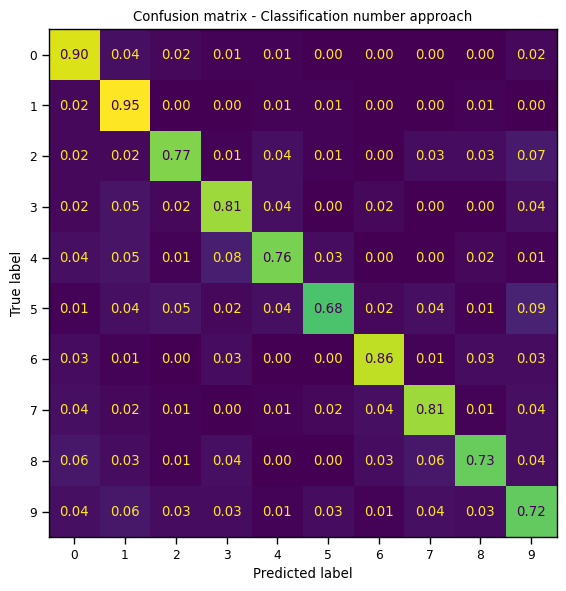

In [25]:
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_0to9,
    y_pred_0to9_classnumber,
    normalize="true",
    values_format=".2f",
    ax=ax
)
ax.images[0].colorbar.remove()
ax.set_title(f"Confusion matrix - Classification number approach")
fig.tight_layout()
fig.savefig(
    f"final_confusion_matrix_classnumber.png",
    dpi=300
)

10. Multiclass with voting

In [26]:
def resolve_tie(labels_series, clas_numbers_dict, all_labels):
    labels_tie = labels_series.loc[lambda x: x.notnull()].astype(int).to_list()
    idx = labels_series.name
    if len(labels_tie) == 1:
        # If there is no tie return the only mode
        return labels_tie[0]
    else:
        # Create dictionary with distances of each tie label
        label_tie_dist_sum = dict(zip(labels_tie, [0] * len(labels_tie)))
        # Compare against every other digit
        for label_tie, label in product(labels_tie, all_labels):
            if label_tie == label:
                # Same label - Do not consider this case
                continue
            # Class number dictionary is ordered
            if label_tie < label:
                class_number = clas_numbers_dict[(label_tie, label)][idx]
                if class_number < 0:
                    # Add the distance if it was marked as the label
                    label_tie_dist_sum[label_tie] += np.abs(class_number)
            else:
                class_number = clas_numbers_dict[(label, label_tie)][idx]
                if class_number > 0:
                    # Add the distance if it was marked as the label
                    label_tie_dist_sum[label_tie] += np.abs(class_number)
        return max(label_tie_dist_sum, key=label_tie_dist_sum.get)  # Argmax

In [27]:
svm_pairs_pred = {}
svm_pairs_clas_numbers = {}
for label_1, label_2 in combinations(labels_0to9, 2):
    map_dict = {label_1: -1, label_2: 1}  # Map labels to -1 and 1
    map_inv_dict = {v: k for k, v in map_dict.items()}  # Inverse mapping
    # Filter training data of only two labels each iteration
    X_train, y_train = filter_data(X_train_0to9, y_train_0to9, [label_1, label_2])
    y_train_bin = np.vectorize(map_dict.get)(y_train)  # Labels to -1 or 1
    svm = SVM_binary(C=C, gamma=gamma)
    svm.train(X_train, y_train_bin)
    # Prediction on all test dataset
    y_pred_bin = svm.predict(X_test_0to9)
    class_numbers = svm.predict(X_test_0to9, return_class_number=True)
    y_pred = np.vectorize(map_inv_dict.get)(y_pred_bin)  # 1 or -1 to labels
    svm_pairs_pred[(label_1, label_2)] = y_pred
    svm_pairs_clas_numbers[(label_1, label_2)] = class_numbers
# Get the mode of each test sample
pair_pred_mode = pd.DataFrame(svm_pairs_pred.values()).T.mode(axis=1)


In [28]:
# Resolve tie
y_pred_0to9_vote = (
    pair_pred_mode.apply(resolve_tie, args=(svm_pairs_clas_numbers, labels_0to9), axis=1)
    .to_numpy()
)
accuracy_vote = np.mean(y_test_0to9 == y_pred_0to9_vote)
accuracy_vote

0.931

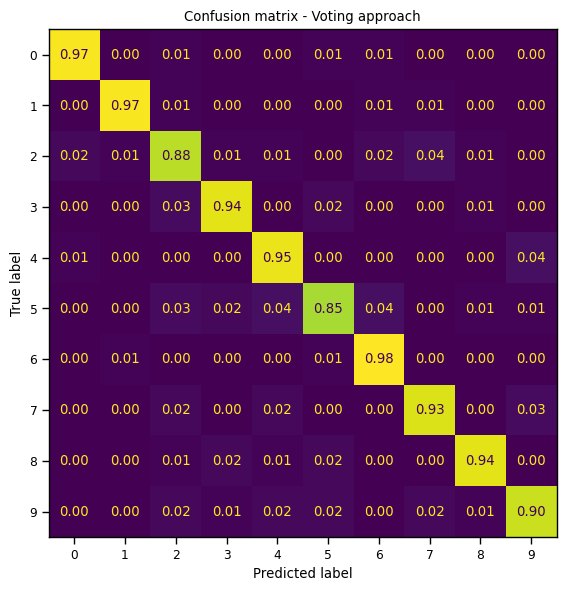

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_0to9,
    y_pred_0to9_vote,
    normalize="true",
    values_format=".2f",
    ax=ax
)
ax.images[0].colorbar.remove()
ax.set_title(f"Confusion matrix - Voting approach")
fig.tight_layout()
fig.savefig(
    f"final_confusion_matrix_vote.png",
    dpi=300
)